# Описание проекта

Компания занимается продажей продуктов питания через мобильное приложение, и нам необходимо изучить поведение пользователей приложения. Для этого нам нужно проанализировать воронку продаж, чтобы понять, как пользователи доходят до покупки, и сколько из них застревает на предыдущих этапах. После этого мы проведем A/A/B-тест, чтобы определить, какой шрифт лучше подходит для нашего приложения.

Также, нам необходимо создать две контрольные группы с разными шрифтами и одну экспериментальную группу. Это поможет обеспечить точность тестирования и выявить факторы, которые могут повлиять на результаты. Сравнение контрольных групп также позволит оценить необходимое время и объем данных для дальнейших тестов.

Важно помнить, что в реальных проектах всегда проводятся эксперименты, и аналитики должны учитывать данные из всех источников для анализа качества работы приложения.

Описание данных
* Каждая запись в логе — это действие пользователя, или событие. 
* EventName — название события;
* DeviceIDHash — уникальный идентификатор пользователя;
* EventTimestamp — время события;
* ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## Открытие файла с данными и изучение общей информации

In [1]:
#подключим все необходимые бибилотеки для исследования
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import warnings
warnings.filterwarnings("ignore") 
from scipy import stats as st
import math as mth
import numpy as np
import plotly.express as px

In [2]:
#загрузим датасет
try:
    data_logs = pd.read_csv('logs_exp.csv', sep = '\t')
except FileNotFoundError:
    data_logs = pd.read_csv('/datasets/logs_exp.csv', sep = '\t')

In [3]:
#просмотрим данные
data_logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [4]:
data_logs.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


## Подготовка данных
### Изменение названия столбцов с данными

In [5]:
#Чтобы часть столбцов в дальнейшем не скрывалась, настроим принудительное отображение
pd.set_option('max_colwidth', 200)

In [6]:
#изменим названия столбцов на более удобные и привычные для чтения
data_logs.columns = ['event_name', 'device_id_hash', 'event_timestamp', 'exp_id']
#проверим названия столбцов
data_logs.columns.to_list()

['event_name', 'device_id_hash', 'event_timestamp', 'exp_id']

### Проверка пропусков и типов данных

In [7]:
#проверим данные на дубликаты
data_logs.duplicated().sum()

413

In [8]:
#удалим дубликаты
data_logs = data_logs.drop_duplicates().reset_index(drop=True)

In [9]:
#просмотрим все уникальные значения в столбце event_name
print(data_logs['event_name'].value_counts())

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64


In [10]:
#найдем все строки с пропусками
data_logs['event_name'].isna().count()

243713

In [11]:
#и сравним с общим количеством строк
data_logs['event_name'].count()

243713

Пропусков нет

### Добавление столбца даты и времени. Добавление отдельного столбца дат

In [12]:
#добавим столбец с датой и временем,а также отдельный столбец только с датой
data_logs['datetime'] = pd.to_datetime(data_logs['event_timestamp'], unit = 's')
#параметр unit=s сообщает, что нужно перевести время с точностью до секунды
data_logs['date'] = pd.to_datetime(data_logs['datetime']).dt.date
data_logs.head()

,event_name,device_id_hash,event_timestamp,exp_id,datetime,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


## Изучение и проверка данных

### Количество событий в логе

In [13]:
print('Количество событий в логе: ', data_logs['event_name'].count())

Количество событий в логе:  243713


### Количество пользователей в логе

In [14]:
print('Количество пользователей в логе: ', data_logs['device_id_hash'].nunique())

Количество пользователей в логе:  7551


### Среднее количество событий на пользователя

In [15]:
print('Среднее количество событий на пользователя: ', data_logs.groupby('device_id_hash')['event_name'].agg('count').median())

Среднее количество событий на пользователя:  20.0


### Определение периода данных: минимальная и максимальая дата

In [16]:
print('В логах содержатся данные за период: с {} по {}.'.format(data_logs['datetime'].min(), data_logs['datetime'].max()))

В логах содержатся данные за период: с 2019-07-25 04:43:36 по 2019-08-07 21:15:17.


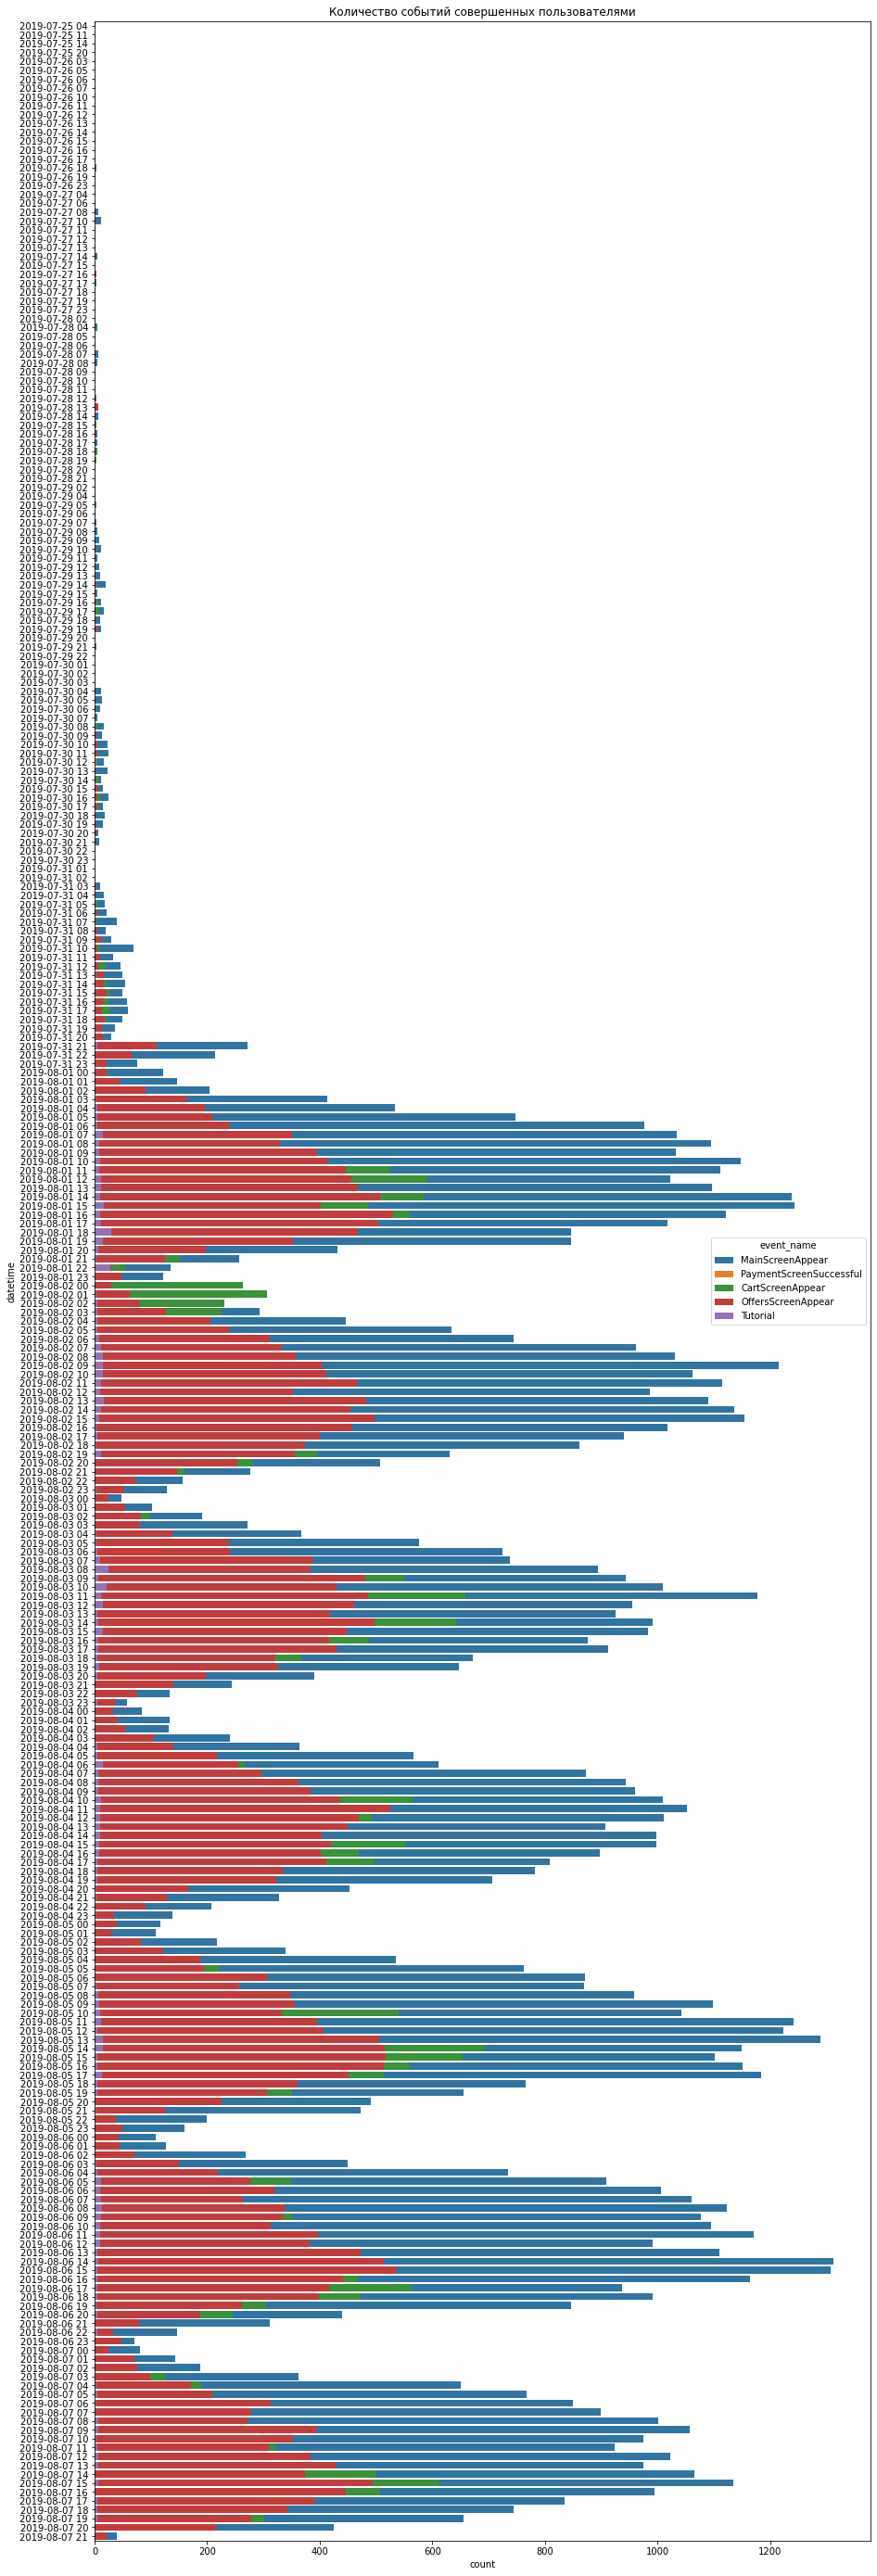

In [17]:
#гистограмма по дате и времени
plt.figure(figsize=(15,50))
hist = sns.countplot(y=data_logs['datetime'].dt.strftime('%Y-%m-%d %H'), hue='event_name', data=data_logs, dodge=False)
hist.set_title('Количество событий совершенных пользователями');

Можно ли быть уверенным, что у вас одинаково полные данные за весь период? Нет

Глядя на построенную гистограмму по дате и времени, мы видим, что одинаково полные данные есть только за период с 31 июля 2019 21:00 по 07 августа 2019 года 21:00. Построим новую гистограмму, отбросив более старые данные

Text(0.5, 1.0, 'Количество событий совершенных пользователями')

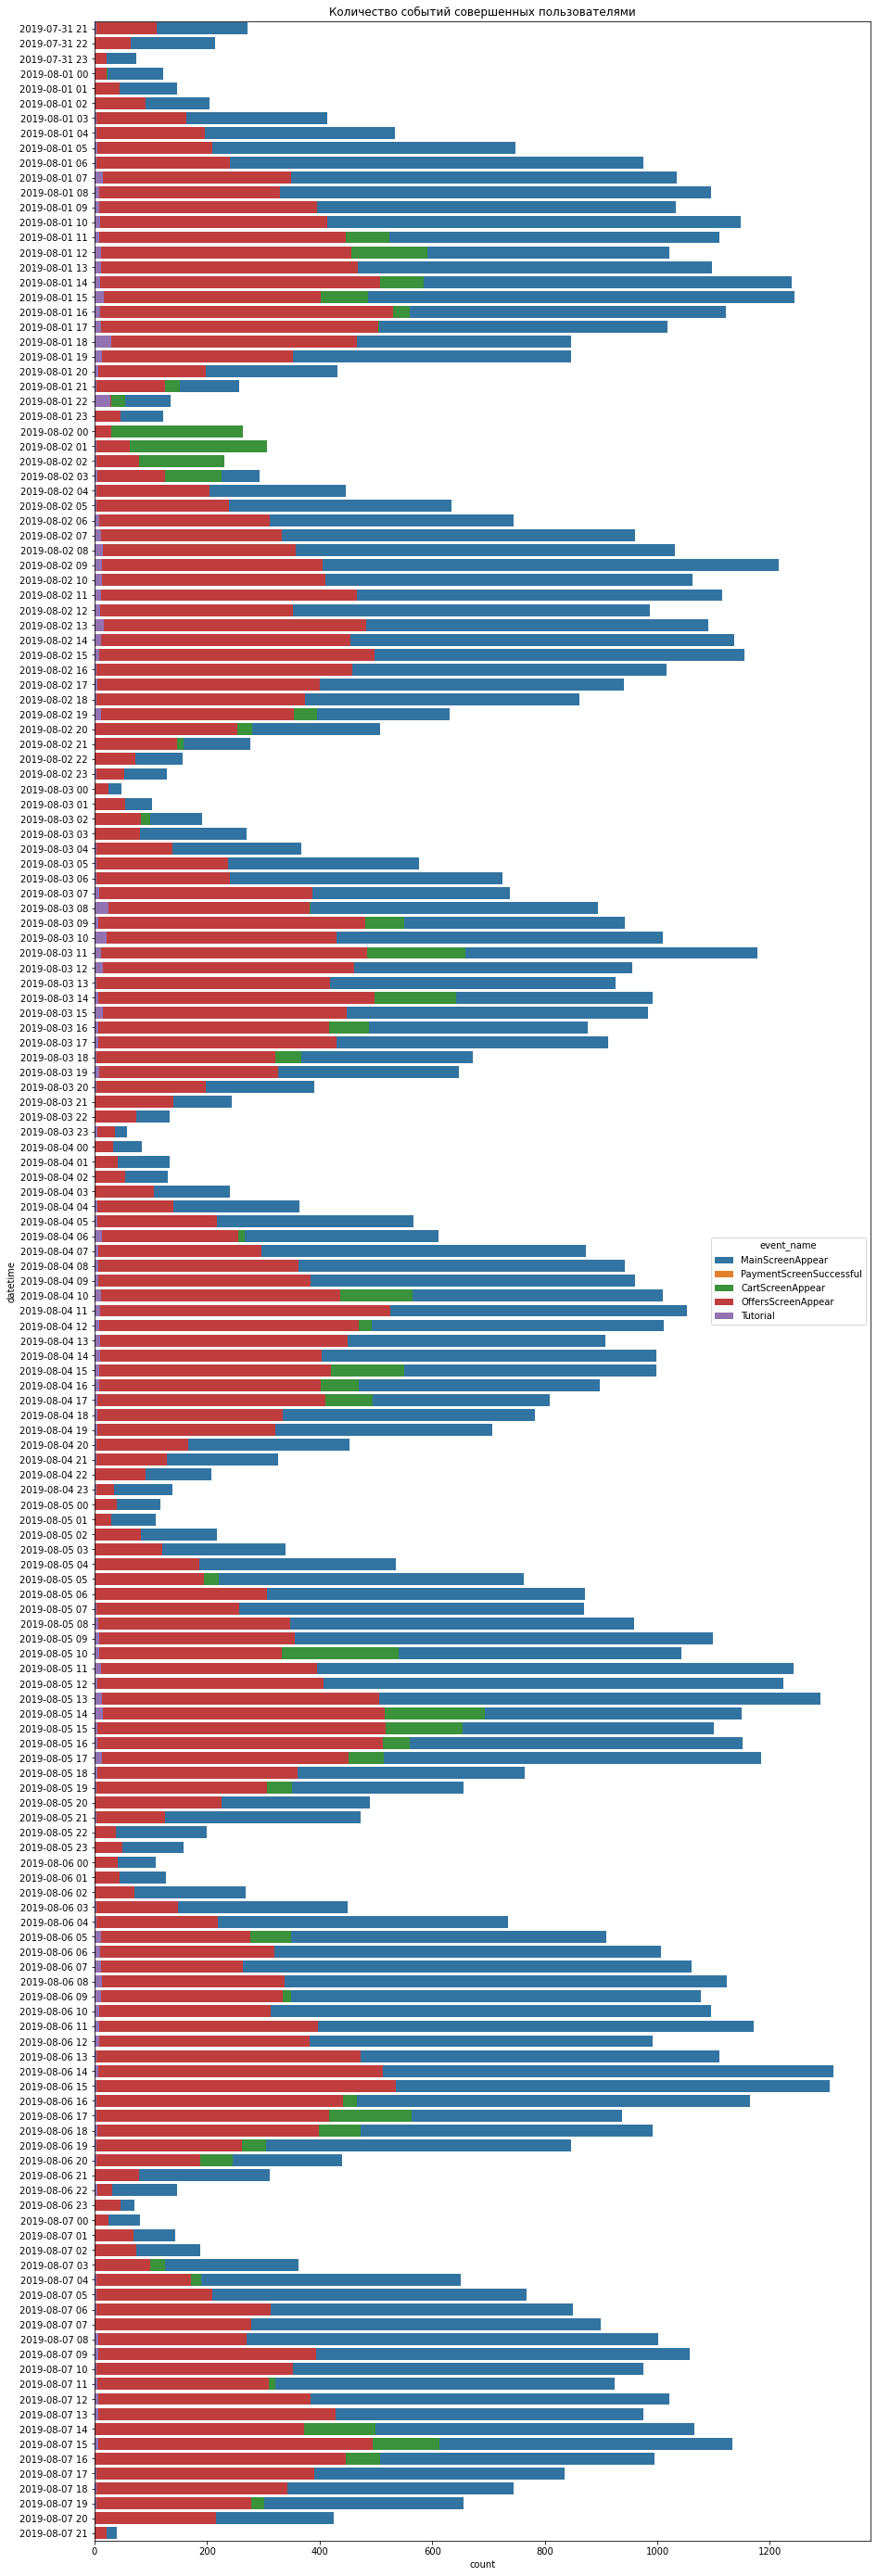

In [18]:
data_logs_clear = data_logs['2019-07-31 21:00' <= data_logs['datetime']]
plt.figure(figsize=(15,50))
hist = sns.countplot(y=data_logs_clear['datetime'].dt.strftime('%Y-%m-%d %H'), hue='event_name', data=data_logs, dodge=False)
hist.set_title('Количество событий совершенных пользователями')

### Определим, много ли событий и пользователей мы потеряли, отбросив старые данные

In [19]:
print('Количество событий после чистки данных:', len(data_logs_clear['event_name']), '; процент событий от первоначальных данных:',
      round(len(data_logs_clear['event_name'])/len(data_logs['event_name'])*100,2))
print('Количество пользователей после чистки данных:', len(data_logs_clear['device_id_hash'].unique()), '; процент пользователей от первоначальных данных:',
      round(data_logs_clear['device_id_hash'].nunique()/data_logs['device_id_hash'].nunique()*100,2))

Количество событий после чистки данных: 241724 ; процент событий от первоначальных данных: 99.18
Количество пользователей после чистки данных: 7538 ; процент пользователей от первоначальных данных: 99.83


Делаем вывод, что у нас потеряно менее 1% данных с событями и около 0,17% данных с пользователями

### Проверка наличия всех пользователей во всех группах

In [20]:
data_logs_clear['exp_id'].unique()

array([247, 248, 246])

Все три группы остались в данных

В имюещемся логе содержится 243713 событий. Пользователи их совершавшие 7551. В среднем на одного пользователя приходится 20 событий. Логи сдожержат данные за период с 2019-07-25 04:43:36 по 2019-08-07 21:15:17. Построив график по всем событиям, мы видим, что одинаково полные данные есть только за период с 31 июля 2019 21:00 по 07 августа 2019 года 21:00. Произвели отбор данных с 31 июля 2019 21:00 для дальнейшего анализа данных. Также, после урезания объема данных было установлено, что количество событий после чистки сократилось на 0,72%, а пользователей на 0,17%. Все пользователи сохранились во всех группах

## Изучение результатов эксперимента

### Какие события есть в логах и как часто они встречаются

In [21]:
#сгруппируем данные по названию события и посчитаем их количество
funnel = (
    data_logs_clear.groupby(['event_name']).agg({'event_name':'count'})
    .rename(columns={'event_name':'event_count'})
    .sort_values(by='event_count', ascending = False)
    .reset_index()
        )
funnel.head()

,event_name,event_count
0,MainScreenAppear,117889
1,OffersScreenAppear,46531
2,CartScreenAppear,42343
3,PaymentScreenSuccessful,33951
4,Tutorial,1010


### Сколько пользователей совершали каждое из этих событий. Расчет доли пользователей

In [22]:
#рассчитаем количество пользователей совершивших каждое событие(пользователеи которые дошли до последнего события - покупки)
funnel = (
    data_logs_clear.groupby(['event_name']).agg({'event_name':'count', 'device_id_hash': 'nunique'})
    .rename(columns={'event_name':'event_count', 'device_id_hash':'user_count'})
    .sort_values(by='event_count', ascending = False)
    .reset_index()
              )
funnel.head()

,event_name,event_count,user_count
0,MainScreenAppear,117889,7423
1,OffersScreenAppear,46531,4597
2,CartScreenAppear,42343,3736
3,PaymentScreenSuccessful,33951,3540
4,Tutorial,1010,843


In [23]:
# рассчитаем долю пользователей на каждом шаге воронки
funnel['converse'] = (funnel['user_count'] / len(data_logs_clear['device_id_hash'].unique()) * 100).round(2)
funnel

,event_name,event_count,user_count,converse
0,MainScreenAppear,117889,7423,98.47
1,OffersScreenAppear,46531,4597,60.98
2,CartScreenAppear,42343,3736,49.56
3,PaymentScreenSuccessful,33951,3540,46.96
4,Tutorial,1010,843,11.18


### Определение порядка совершения событий

Text(0.5, 0, 'Наименование событий')

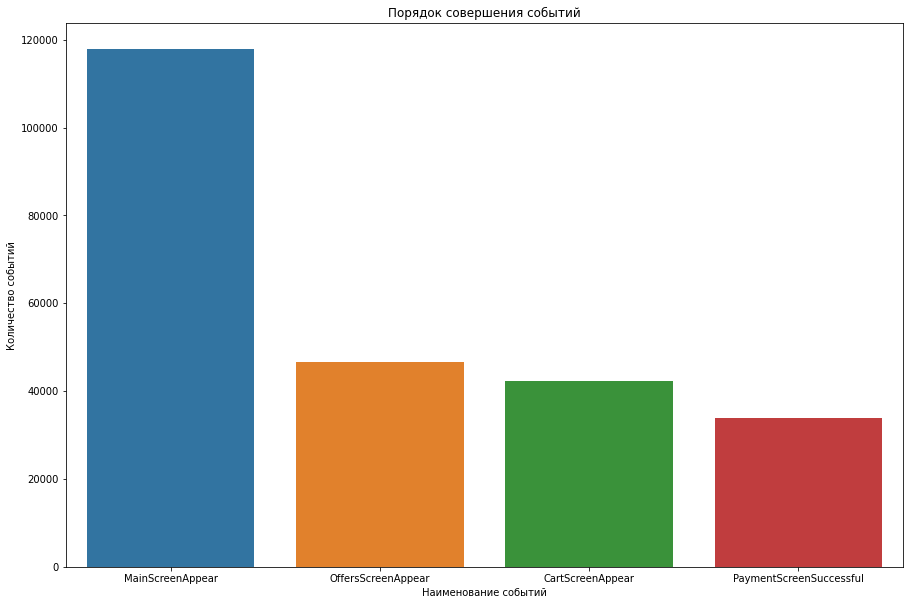

In [24]:
funnel2 = funnel.query('event_name != "Tutorial"')
plt.figure(figsize=(15,10))
plt.title('Порядок совершения событий')
sns.barplot(data=funnel2, x='event_name', y ='event_count')
plt.ylabel('Количество событий')
plt.xlabel('Наименование событий')

Порядок соврешения события будет таким же как и на диаграмме:
* MainScreenAppear - пользователь попадает на главный экран
* OffersScreenAppea - пользователь переходит на экран предложения к покупке
* CartScreenAppear - пользователь попадает в корзину
* PaymentScreenSuccessful - пользователь видит страницу с успешным исполнением платежа

Также, есть еще одна страница на которую пользователи заходят реже всего. Это Tutorial. Этот шаг можно выполнить в любой момент и в общую цепочку его добавлять не будем

### Расчет доли пользователей которые проходят на следующий шаг воронки(от числа пользователей на предыдущем).

In [25]:
#сдвинем одно событие относительно другого на одну строку
funnel2['shift'] = funnel2['user_count'].shift()
#рассчитаем соотношение числа пользователей текущего шага к предыдущему
funnel2['conversion'] = funnel2['user_count'] / funnel2['shift'] *100
#удалим столбец, по большей части технический
funnel2.drop(columns= ['shift'], axis = 1, inplace = True)
funnel2

,event_name,event_count,user_count,converse,conversion
0,MainScreenAppear,117889,7423,98.47,NaN
1,OffersScreenAppear,46531,4597,60.98,61.929139
2,CartScreenAppear,42343,3736,49.56,81.270394
3,PaymentScreenSuccessful,33951,3540,46.96,94.753747


### На каком шаге теряется больше всего пользователей?
На шаге 2 теряется больше всего пользователей: переход с главной страницы на страницу с предложением о покупке. Здесь потеря составляет 38%

### Определение доли пользователей которая доходит от первого события до оплаты

От первого события до оплаты доходит 47% пользователей

## Изучение результатов эксперимента

### Расчет количества пользователей в каждом эксперименте группы

In [26]:
#рассчитаем количество пользователей в каждой группе
count_users = data_logs_clear.groupby('exp_id')['device_id_hash'].nunique()
#добавим объединенную группу 246 и 247
count_users['246+247'] = count_users[246] + count_users[247] #добавим столбец с объединенными контрольными группами
count_users.head()

exp_id
246        2484
247        2517
248        2537
246+247    5001
Name: device_id_hash, dtype: int64

In [27]:
#количество пользователей с разбивкой по группам без события Tutorial
count_users_all = data_logs_clear[data_logs_clear['event_name'] != 'Tutorial']\
    .pivot_table(index='event_name', columns='exp_id', values='device_id_hash', aggfunc='nunique')\
    .sort_values(by=246, ascending=False)
count_users_all['246+247'] = count_users_all[246] + count_users_all[247] #добавим столбец с объединенными контрольными группами
count_users_all.head()

exp_id,246,247,248,246+247
event_name,,,,
MainScreenAppear,2450,2479,2494,4929
OffersScreenAppear,1542,1524,1531,3066
CartScreenAppear,1266,1239,1231,2505
PaymentScreenSuccessful,1200,1158,1182,2358


### А/А эксперимент
Для проверки корректности всех механизмов и расчётов мы имеем 2 контрольные группы для проведения А/А-эксперимента. Наша задача - определить, существует ли статистически значимая разница между выборками 246 и 247.

Критерии успешного A/A-теста: 
* Количество пользователей в различных группах различается не более, чем на 1%;
* Для всех групп фиксируют и отправляют в системы аналитики данные об одном и том же;
* Различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости;
* Попавший в одну из групп посетитель остаётся в этой группе до конца теста. Если пользователь видит разные версии исследуемой страницы в ходе одного исследования, неизвестно, какая именно повлияла на его решения. Значит, и результаты такого теста нельзя интерпретировать однозначно.

In [28]:
#Отличие сравниваемых размеров групп
print(round(count_users[246]/count_users[247], 2))
print(round(count_users[246]/count_users[248], 2))
print(round(count_users[247]/count_users[248], 2))

0.99
0.98
0.99


Группы отличаются друг от друга не более чем, на 1%

In [29]:
data_logs_clear.groupby('device_id_hash')['exp_id'].nunique().reset_index().query('exp_id >1').count()

device_id_hash    0
exp_id            0
dtype: int64

Пользователи, попавшие в несколько групп, отсутствуют

### Тесты с самым популярным событием
Самое популярное событие - MainScreenAppear (переход на главный экран). Для проведения Z-теста сформулируем гипотезы:
* H0 - доли пользователей дошедших до события в контрольных группых равны
* H1 - доли пользователей дошедших до события в контрольных группах различны

Составим функцию для проведения z-test и проведем для самого популярного события MainScreenAppear

In [30]:
def z_test (group1, group2, alpha, event):
    alpha = alpha # критический уровень статистической значимости

    #возьмем выборки для события и выбранных контрольных групп
    successes_1 = count_users_all.loc[event, group1]
    successes_2 = count_users_all.loc[event, group2]

    trials_1 = count_users[group1]
    trials_2 = count_users[group2]

    # пропорция успехов в первой группе:
    p1 = successes_1/trials_1

    # пропорция успехов во второй группе:
    p2 = successes_2/trials_2

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes_1 + successes_2) / (trials_1 + trials_2)

    # разница пропорций в датасетах
    difference = p1 - p2

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials_1 + 1/trials_2))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

In [31]:
z_test(246,247,0.01,'MainScreenAppear')

p-значение:  0.6756217702005545
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Выполним Z-тест для события OffersScreenAppear

In [32]:
z_test(246,247,0.01,'OffersScreenAppear')

p-значение:  0.26698769175859516
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Выполним Z-тест для события CartScreenAppear

In [33]:
z_test(246,247,0.01,'CartScreenAppear')

p-значение:  0.2182812140633792
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Выполним Z-тест для события PaymentScreenSuccessful:

In [34]:
z_test(246,247,0.01,'PaymentScreenSuccessful')

p-значение:  0.10298394982948822
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Две используемые группы - контрольные. При проведении Z теста для каждого события у нас был отвержена нулевая гипотеза о равенстве групп. Значит, можно сказать, что разбиение на группы работает корректно

### Тест всех событий с группой с измененными шрифтами (А/B тест)
Проведем аналогичные тесты с группой с измененным шрифтом и посмотрим, будет ли отличие между группами статистически достоверным. Для проведения Z-теста сформулируем гипотезы:
* H0 - доли пользователей дошедших до события в экспериментальной группе равны
* H1 - доли пользователей дошедших до события в экспериментальной группе различны

In [35]:
#создадим пустой список для записи всех результатов теста
result_test = []
alpha = .01
#используя цикл запишем все результаты тестов
for group in [[246,248], [247,248], ['246+247', 248]]:
    for events in count_users_all.index.values:
        result_test.append(z_test(group[0], group[1], alpha, events))

p-значение:  0.34705881021236484
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.08328412977507749
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.22269358994682742
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.6001661582453706
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.8835956656016957
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.6169517476996997
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.6775413642906454
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.39298914928006035
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-зна

При проведении теста для контрольных групп(и их суммой) с группой с измененными шрифтами не было обнаружено статистически значимых различий между долями пользователяй, совершивших целевое событие

### Выбор уровня значимости при проверке статистических гипотез в предыдущих пунктах


В расчетах был выбран уровень значимости α 0.01 Было сделано 12 тестов. Ни один из тестов с контрольной и тестируемой группой не подтвердил нулевую гипотезу. Можно применить уровень значимости 0.05 который считается самым оптимальным, но из-за того что тестируемые группы достаточно большие изменение уровня ничего не изменит.

# Общий вывод:
Нам были предоставлены данные для анализа которые содержат лог, каждая запись которого - действие пользователя мобильного приложения.

Все действия были разбиты на три группы: две контрольные и одна тестовая, для пользователей которой изменен шрифт приложения. Целью исследованиея было разобраться, изменилась ли конверсия события в тестовой группе.

В начале была произведена предобработка данных. В результате:
* наименования столбцов были приведены к удобному виду
* созданы столбец timestmap с датой и временем и столбец date с выделенной датой
* удалено 413 дубликатов

Поскольку о полноте данных можно говорить только с 01.08.2019, датафрейм был очищен от периода с 25.07.2019 по 31.07.2019: в итоге после "очистки" потеряно чуть более 1% событий и всего 0,17% пользователей. Осталось 241724 события 7538 пользователей.

Результаты исследования:
В результате исследования был проведен А/А эксперимент который показал, что контрольные группы отличаются друг от друга не более чем на 1%, а также нет пользователей поавших в несколько групп. Это критерии успешного А/А теста.
Далее, был произведены z тест с самым популярным событием MainScreenAppear (переход на главный экран). Для проведения были сформулированы гипотезы:
* H0 - доли пользователей дошедших до события в контрольных группых равны
* H1 - доли пользователей дошедших до события в контрольных группах различны

Тест показал, что нулевую гипотезу отвергнуть не получилось. Коэффициент статистической значимости был выбран 0.01 из-за достаточно большой выборки.

Далее, был произведен А/В эксперимент. Гипотезы были оставлены те же, только сравнивали котнрольные группы с группой с измененными шрифтами для пользователей. Было произведено 12 тестов(для каждой группы и каждого события по отдельности) которые также показали, что нулевую гипотезу отвергнуть не получилось. В данном случае стоит использовать поправки на множественное сравнение, но так как в тесте мы не отвергали нулевеую гипотезу, то применение поправок реузльтата не изменит.